# A GPT2-based Model

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Introduction

In [ ]:
# !pip install tokenizers>=0.14
# # Install transformers library.
# !pip install -q git+https://github.com/huggingface/transformers.git
# # Install helper functions.
# !pip install -q git+https://github.com/gmihaila/ml_things.git

In [ ]:
# !pip install transformers -U

In [ ]:
# !pip install pandas numpy seaborn matplotlib torch tqdm tokenizers ipywidgets

In [ ]:
import pandas as pd
import random
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import set_seed
from transformers import TrainingArguments
from transformers import Trainer
from transformers import GPT2Config
from transformers import GPT2Tokenizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import GPT2ForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

: 

In [ ]:
def shuffle(df):
    num_rows = df.shape[0]

    # Generate random indices
    random_indices = random.sample(range(num_rows), num_rows)

    # Shuffle dataframe rows based on random indices
    df = df.loc[random_indices]

    return df

: 

In [7]:
# drive = "/content/drive/MyDrive/TAP-Semantic-Consistency-Checking-main/"

In [8]:
path = 'datasets/Data_Review/'

In [9]:
# def set_label(x):
#     if(x==1):
#         return "Fake"
#     else:
#         return "Real"

In [10]:
train_path = path + 'training set contenente fake (generate) e real.csv'

col_names = ['ID','Title','content', 'label']
train_df = shuffle(pd.read_csv(train_path,sep=';',names=col_names,encoding = "ISO-8859-1"))

# train_df['label'] = train_df['label'].apply(lambda x: set_label(x) )
train_df

,ID,Title,content,label
34,35,Right,"as described by others, the length is a littl...",Real
677,678,Terrible,purchased based on the reviews but total disa...,Real
266,267,THEY LASTED A DAY,I was happy to have found comfortable headpho...,Real
861,862,Good product,Good product and a little and I can start by s...,Fake
1471,1472,Good cover,Good cover in a nice PC. An interior of severa...,Fake
...,...,...,...,...
208,209,Exaggerated bass. Excellent battery life. I wa...,the sound is good and the fit too. it's a sha...,Real
1764,1765,Massager for muscle recovery,The product is certainly of quality. I didn't...,Fake
1636,1637,strong smell like solvent and small rubber bands,strong smell like solvent and small rubber ba...,Fake
1638,1639,Good quality Fpp2 mask,Good quality Fpp2 mask. The sound quality is a...,Fake


In [11]:
# val_path = 'devSet.csv'

# valid_df = pd.read_csv(val_path,skiprows=1,sep=';',names=col_names,encoding = "ISO-8859-1")

# valid_df

In [12]:
test_path = path + 'test set contenente fake (generate) e real.csv'

test_df = shuffle(pd.read_csv(test_path,sep=';',names=col_names,encoding = "ISO-8859-1"))

# test_df['label'] = test_df['label'].apply(lambda x: set_label(x) )
test_df

,ID,Title,content,label
28,29,Highly recommended,I purchased this watch for my nephew and I can...,Fake
18,19,More than it seems,I bought the balloons for a birthday. The qual...,Fake
133,134,Excellent for high beams,Excellent for high beams. Excellent value for...,Fake
100,101,They last a week,They last a week for mine. It's its duty. I bo...,Fake
129,130,Good-made Fpp2 mask,Good-made Fpp2 mask. The sound quality is also...,Fake
...,...,...,...,...
36,37,Excellent,"Excellent product as described, it holds very ...",Fake
79,80,Good quality Fpp2 mask,purchased hesitantly but when tested they wer...,Real
6,7,Small but powerful,"The antenna in question works really well, it ...",Fake
105,106,Low quality adhesive applicator too narrow,Low quality adhesive applicator too narrow for...,Fake


In [13]:
# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 10

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 100

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'Real': 0, 'Fake': 1}
# labels_ids = {0 : 'Real', 1 : 'Fake'}


# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [14]:
class ReviewDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, dataset, use_tokenizer):
    self.texts = []
    self.labels = []

    for i in range(len(dataset)):
      # text = "Title = " + str(dataset.iloc[i]['Title']) + "; Content = " + str(dataset.iloc[i]['content'])
      text = "Content = " + str(dataset.iloc[i]['content'])

      # Save content.
      self.texts.append(text)
      # Save encode labels.
      self.labels.append(dataset.iloc[i]['label'])

    # Number of examples.
    self.n_examples = len(self.labels)

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and
      asociated labels.

    """
    return {'text':self.texts[item],
            'label':self.labels[item]}

In [15]:
class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """
        # print("sequences: ", sequences, "\n")

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # print("texts: ", texts, "\n")

        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]

        # print("labels_1: ", labels, "\n")
        # print("labels_3: ", sequences, "\n")

        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # print("labels_2: ", labels, "\n")

        # Call tokenizer on all texts to convert into tensors of numbers with
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [16]:
def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [17]:
def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

In [18]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [19]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = ReviewDataset(train_df,
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

# print('Dealing with Validation...')
# # Create pytorch dataset.
# valid_dataset =  ReviewDataset(,
#                                use_tokenizer=tokenizer)
# print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
# print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 1806 examples!
Created `train_dataloader` with 57 batches!



C:\Users\giand\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...
Epoch  0 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  1 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  2 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  3 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  4 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  5 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  6 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  7 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  8 ...


  0%|          | 0/57 [00:00<?, ?it/s]


Training on batches...
Epoch  9 ...


  0%|          | 0/57 [00:00<?, ?it/s]

C:\Users\giand\AppData\Roaming\Python\Python39\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


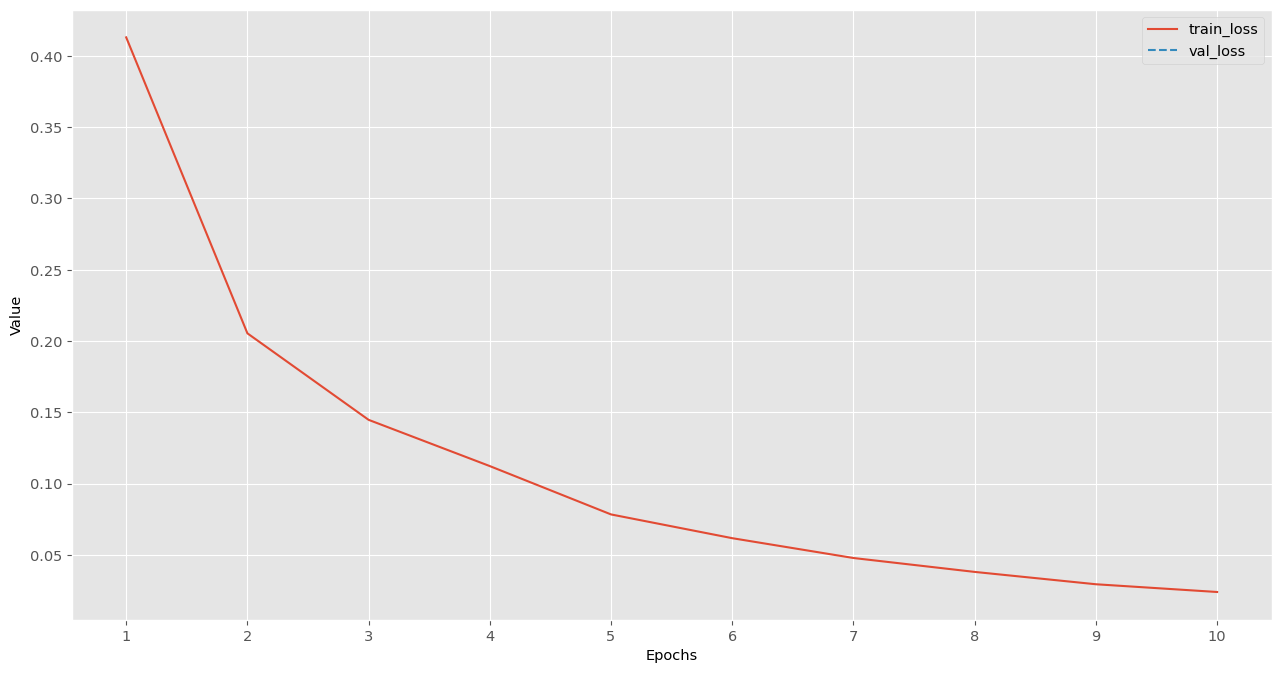

C:\Users\giand\AppData\Roaming\Python\Python39\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


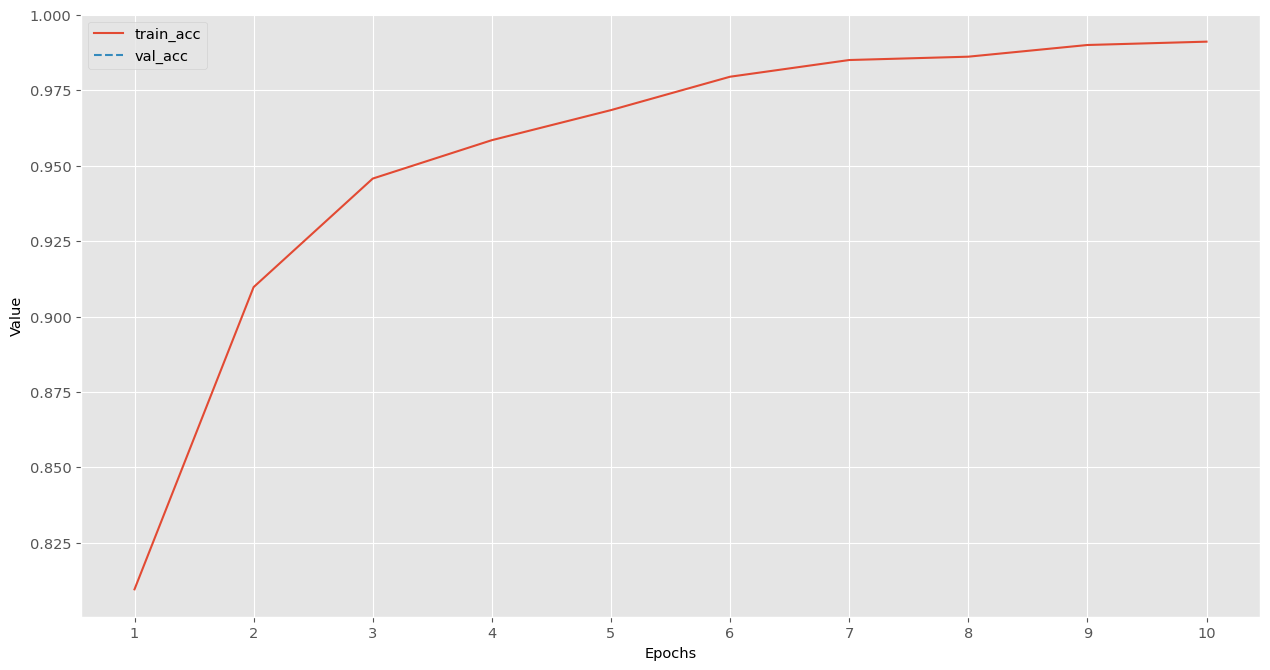

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  print('Epoch ',epoch,'...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  # print('Validation on batches...')
  # valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  # val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  # print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  # print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  # all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  # all_acc['val_acc'].append(val_acc)

  # Save the model
  output_model_file = 'models/gpt2_amazonreviews_',epoch,'.pt',

  model_to_save = model
  torch.save(model_to_save, output_model_file)

  print('All files saved\n')

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [29]:
print('Dealing with Evaluation...')
# Create pytorch dataset.
test_dataset =  ReviewDataset(test_df,
                               use_tokenizer=tokenizer)
print('Created `test_dataset` with %d examples!'%len(test_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

Dealing with Evaluation...
Created `test_dataset` with 150 examples!
Created `test_dataloader` with 5 batches!


  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94        50
        Fake       0.96      0.98      0.97       100

    accuracy                           0.96       150
   macro avg       0.96      0.95      0.95       150
weighted avg       0.96      0.96      0.96       150



In [30]:
# class_mapping = {'Real': 0, 'Fake': 1}
class_mapping = { 0 :'Real',  1 : 'Fake'}

true_labels = [class_mapping[label] for label in true_labels]

predictions_labels = [class_mapping[label] for label in predictions_labels]

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


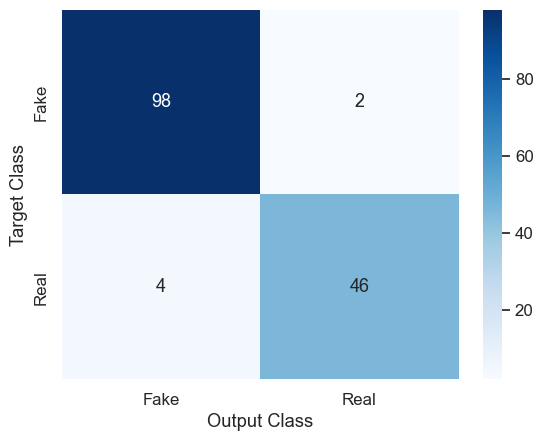

In [31]:
confusion_matrix = pd.crosstab(true_labels, predictions_labels, rownames=['Target Class'], colnames=['Output Class'])

sn.set(font_scale=1.1) # for label size
sn.heatmap(confusion_matrix, annot=True, fmt=".0f", annot_kws={"size": 13}, cmap='Blues')

plt.show()

In [33]:
test_error = pd.DataFrame({'true_label': true_labels, 'result': predictions_labels})

test_error.to_csv('Results/test_results_GPT2.csv')
# test_error.to_csv(drive+'Results/test_results_T5.csv')

# !cp test_semantic_results_GPT2.csv "Results"

In [34]:
test_path = 'Results/test_results_GPT2.csv'
# test_path = drive+'Results/test_results_T5.csv'

col_names = ['true_label','result']
test_error = pd.read_csv(test_path,skiprows=1,sep=',',names=col_names,encoding = "ISO-8859-1")

test_error

,true_label,result
0,Fake,Fake
1,Real,Real
2,Fake,Fake
3,Fake,Fake
4,Fake,Fake
...,...,...
145,Fake,Fake
146,Fake,Fake
147,Real,Real
148,Fake,Fake


In [35]:
data = pd.DataFrame({'prediction':test_error['result'], 'true_label':test_error['true_label']})

# precision tp / (tp + fp)
precision = precision_score(data['true_label'], data['prediction'], average = 'macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(data['true_label'], data['prediction'], average = 'macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(data['true_label'], data['prediction'], average = 'macro')
print('F1 score: %f' % f1)

Precision: 0.959559
Recall: 0.950000
F1 score: 0.954536


# Test LLMs

In [7]:
import shutil

def answer(df,llm):
    path_llm = 'Results/'+llm+"/"

    if(os.path.exists(path_llm)):
        shutil.rmtree(path_llm)
        os.makedirs(path_llm)
    else:
        os.makedirs(path_llm)
        
    print('Evaluation for '+llm+'...')
    # Create pytorch dataset.
    test_dataset =  ReviewDataset(df,
                                use_tokenizer=tokenizer)
    print('Created `test_dataset` with %d examples!'%len(test_dataset))

    # Move pytorch dataset into dataloader.
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
    print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

    # Get prediction form model on validation data. This is where you should use
    # your test data.
    true_labels, predictions_labels, avg_epoch_loss = validation(test_dataloader, device)

    # Create the evaluation report.
    evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
    # Show the evaluation report.
    print(evaluation_report)

    # class_mapping = {'Real': 0, 'Fake': 1}
    class_mapping = { 0 :'Real',  1 : 'Fake'}

    true_labels = [class_mapping[label] for label in true_labels]

    predictions_labels = [class_mapping[label] for label in predictions_labels]

    confusion_matrix = pd.crosstab(true_labels, predictions_labels, rownames=['Target Class'], colnames=['Output Class'])

    sn.set(font_scale=1.1) # for label size
    sn.heatmap(confusion_matrix, annot=True, fmt=".0f", annot_kws={"size": 13}, cmap='Blues')

    plt.show()

    test_path = path_llm+'/test_results_GPT2_'+llm+'.csv'

    test_error = pd.DataFrame({'true_label': true_labels, 'result': predictions_labels})

    test_error.to_csv(test_path)

    col_names = ['true_label','result']
    test_error = pd.read_csv(test_path,skiprows=1,sep=',',names=col_names,encoding = "ISO-8859-1")

    data = pd.DataFrame({'prediction':test_error['result'], 'true_label':test_error['true_label']})

    acc = accuracy_score(data['true_label'], data['prediction'])
    # precision tp / (tp + fp)
    precision = precision_score(data['true_label'], data['prediction'], average = 'macro')
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(data['true_label'], data['prediction'], average = 'macro')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(data['true_label'], data['prediction'], average = 'macro')
    print('F1 score: %f' % f1)

    plt.savefig(path_llm+'/Confusion_'+llm+'.pdf')

    with open(path_llm+"/gpt2_predictions_"+llm+".txt", 'w') as f:
        f.write(evaluation_report+"\n")
        f.write("Accuracy "+ str(acc)+"\n")
        f.write("Precision "+ str(precision)+"\n")
        f.write("Sensitivity_recall "+ str(recall)+"\n")
        f.write("F1_score "+ str(f1))

Evaluation for BARD...
Created `test_dataset` with 1736 examples!
Created `test_dataloader` with 55 batches!


  0%|          | 0/55 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.57      0.98      0.72       868
        Fake       0.94      0.25      0.40       868

    accuracy                           0.62      1736
   macro avg       0.75      0.62      0.56      1736
weighted avg       0.75      0.62      0.56      1736



c:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


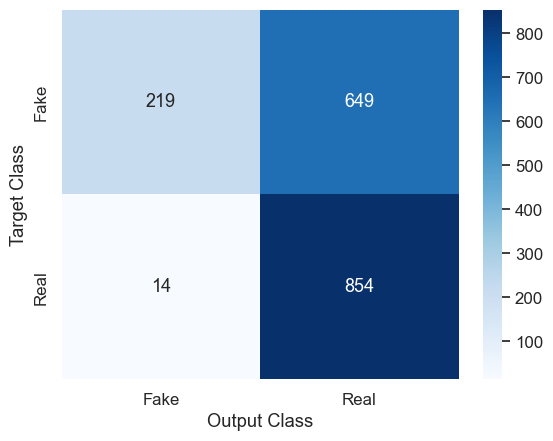

Precision: 0.754056
Recall: 0.618088
F1 score: 0.559096


c:\ProgramData\Anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(




BARD DONE


Evaluation for CLAUDE...
Created `test_dataset` with 1736 examples!
Created `test_dataloader` with 55 batches!


  0%|          | 0/55 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.53      0.98      0.69       868
        Fake       0.90      0.14      0.24       868

    accuracy                           0.56      1736
   macro avg       0.71      0.56      0.47      1736
weighted avg       0.71      0.56      0.47      1736



c:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


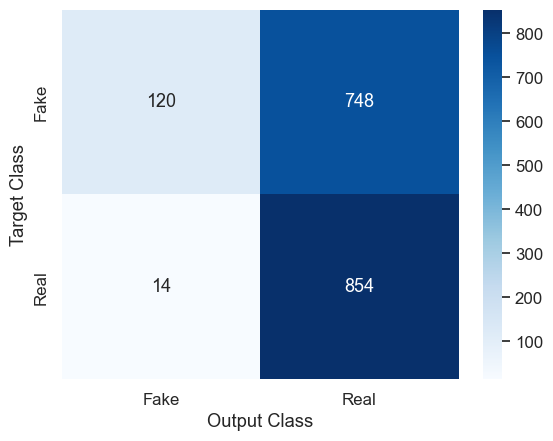

Precision: 0.714303
Recall: 0.561060
F1 score: 0.465509


CLAUDE DONE


Evaluation for GPT...
Created `test_dataset` with 1736 examples!
Created `test_dataloader` with 55 batches!


  0%|          | 0/55 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.60      0.98      0.75       868
        Fake       0.96      0.34      0.51       868

    accuracy                           0.66      1736
   macro avg       0.78      0.66      0.63      1736
weighted avg       0.78      0.66      0.63      1736



c:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


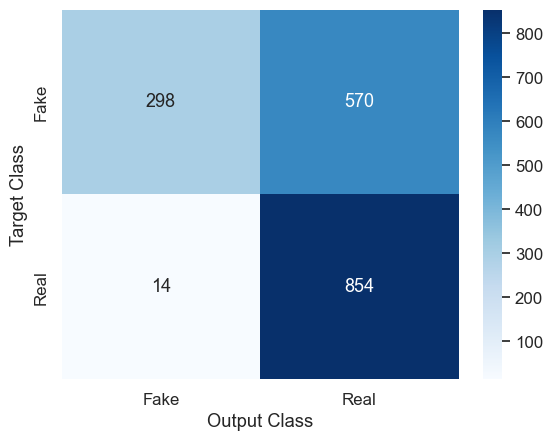

Precision: 0.777424
Recall: 0.663594
F1 score: 0.625143


GPT DONE


Evaluation for LAMA...
Created `test_dataset` with 1736 examples!
Created `test_dataloader` with 55 batches!


  0%|          | 0/55 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       0.59      0.98      0.74       868
        Fake       0.95      0.33      0.49       868

    accuracy                           0.66      1736
   macro avg       0.77      0.66      0.62      1736
weighted avg       0.77      0.66      0.62      1736



c:\ProgramData\Anaconda3\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


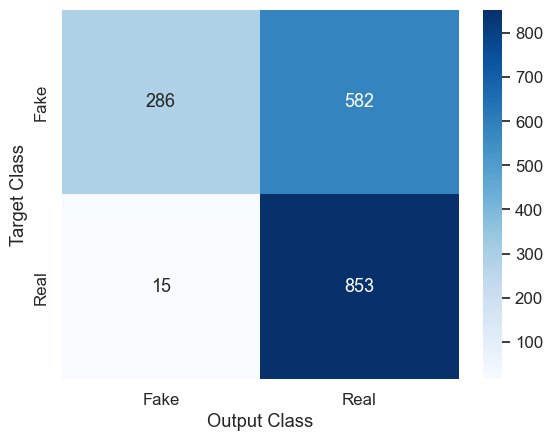

Precision: 0.772296
Recall: 0.656106
F1 score: 0.615040


LAMA DONE




<Figure size 640x480 with 0 Axes>

In [55]:
LLMs = ["BARD", "CLAUDE", "GPT", "LAMA"]
col_names = ['ID','Title','content', 'label']

for llm in LLMs:
    df = pd.read_csv(path+"dataset_" + llm + "_recensioni_generate_eng.csv",names=col_names, sep=';', encoding = "ISO-8859-1")
    answer(df, llm)
    print(f"\n\n{llm} DONE\n\n")